In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from tensorflow.python.framework.ops import disable_eager_execution
from scipy.stats import rankdata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import graphviz

import random


In [2]:
from sklearn.impute import SimpleImputer


disable_eager_execution()

data = pd.read_csv('peru.csv')


print(data.head())


columnas_nonum = data.select_dtypes(exclude=['number']).columns
num_data = data.drop(columns=columnas_nonum)


imputer = SimpleImputer(strategy='mean')
num_data_imputed = imputer.fit_transform(num_data)

# escalado
scaler = StandardScaler()
scaled_data_imputed = scaler.fit_transform(num_data_imputed)
print(scaled_data_imputed)


   Concentración de colágeno (Scl2-SpyTag) en uM  \
0                                            0.5   
1                                            1.0   
2                                            1.5   
3                                            2.0   
4                                            2.5   

   Concentración de elastina (ELP-SpyCatcher) en uM  \
0                                               2.5   
1                                               2.0   
2                                               1.5   
3                                               1.0   
4                                               0.5   

   % de producto (eficiencia de bioconjugación)  
0                                         11.87  
1                                         23.55  
2                                         31.89  
3                                         37.94  
4                                         36.95  
Datos escalados e imputados:
[[-1.25398646 -0.11913223 -

In [3]:
dim_data = scaled_data_imputed.shape[1]
dim_mid = 12
dim_fin = 64
epochs = 500
batch_size = 32



In [4]:
#se construye el codificador modificado, dado que este funcionara con datos tabulares
inputs = Input(shape=(dim_data,))
h = Dense(dim_fin, activation='relu')(inputs)
h = BatchNormalization()(h)
z_mean = Dense(dim_mid)(h)
z_log_var = Dense(dim_mid)(h)



Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# funcion de muestreo
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon # media + varianza * distribucion normal (reparameterization trick)

z = Lambda(sampling)([z_mean, z_log_var])



In [6]:
# decodificador
deco = Dense(dim_fin, activation='relu')
deco_mean = Dense(dim_data, activation='sigmoid')
decoded = deco(z)
outputs = deco_mean(decoded)


vae = Model(inputs, outputs)




In [7]:
def vae_loss(x, x_decoded_mean):
    xent_loss = dim_data * tf.keras.losses.mean_squared_error(x, x_decoded_mean)  # Perdida de reconstruccion para distribucion normal
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  # perdida de divergencia KL
    return K.mean(xent_loss + kl_loss)



In [8]:
vae.compile(optimizer='adam', loss=vae_loss)

# training
vae.fit(scaled_data_imputed, scaled_data_imputed,
        epochs=epochs,
        batch_size=batch_size)




Train on 25 samples
Epoch 1/500
25/25 [==============================] - 2s 100ms/sample - loss: 21.5797
Epoch 2/500
25/25 [==============================] - 0s 747us/sample - loss: 20.3038
Epoch 3/500
25/25 [==============================] - 0s 1ms/sample - loss: 19.0812
Epoch 4/500
25/25 [==============================] - 0s 636us/sample - loss: 18.1623
Epoch 5/500
25/25 [==============================] - 0s 535us/sample - loss: 17.3178
Epoch 6/500
25/25 [==============================] - 0s 565us/sample - loss: 16.3788
Epoch 7/500
25/25 [==============================] - 0s 501us/sample - loss: 15.5818
Epoch 8/500
25/25 [==============================] - 0s 619us/sample - loss: 14.7161
Epoch 9/500
25/25 [==============================] - 0s 876us/sample - loss: 14.1398
Epoch 10/500
25/25 [==============================] - 0s 635us/sample - loss: 13.5601
Epoch 11/500
25/25 [==============================] - 0s 829us/sample - loss: 12.6731
Epoch 12/500
25/25 [=========================

In [9]:

#se define el numero de samples que se necesitan y se genera un espacio latente
samp = 400
dim_mid = vae.input_shape[1]
random_val = np.random.normal(size=(samp, dim_mid))

# se generan los datos sinteticos
y_pred = vae.predict(random_val)
data_sintetica = scaler.inverse_transform(y_pred)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [10]:
# CSV
df_datasint = pd.DataFrame(data_sintetica, columns=num_data.columns)
df_datasint.to_csv('data_sintetica.csv', index=False)
print(df_datasint.head())

data = pd.read_csv('peru.csv')

col= list(data.columns)
df_final = pd.concat([data[col], df_datasint[col]], axis=0)
df_final.to_csv('data_final.csv', index=False)
print(df_final.head())

   Concentración de colágeno (Scl2-SpyTag) en uM  \
0                                       2.374547   
1                                       2.330566   
2                                       2.680895   
3                                       2.350939   
4                                       3.552522   

   Concentración de elastina (ELP-SpyCatcher) en uM  \
0                                          2.806944   
1                                          2.769984   
2                                          3.315744   
3                                          2.773150   
4                                          3.893193   

   % de producto (eficiencia de bioconjugación)  
0                                     42.681198  
1                                     41.656384  
2                                     44.735271  
3                                     42.385975  
4                                     52.849789  
   Concentración de colágeno (Scl2-SpyTag) en uM  \
0   

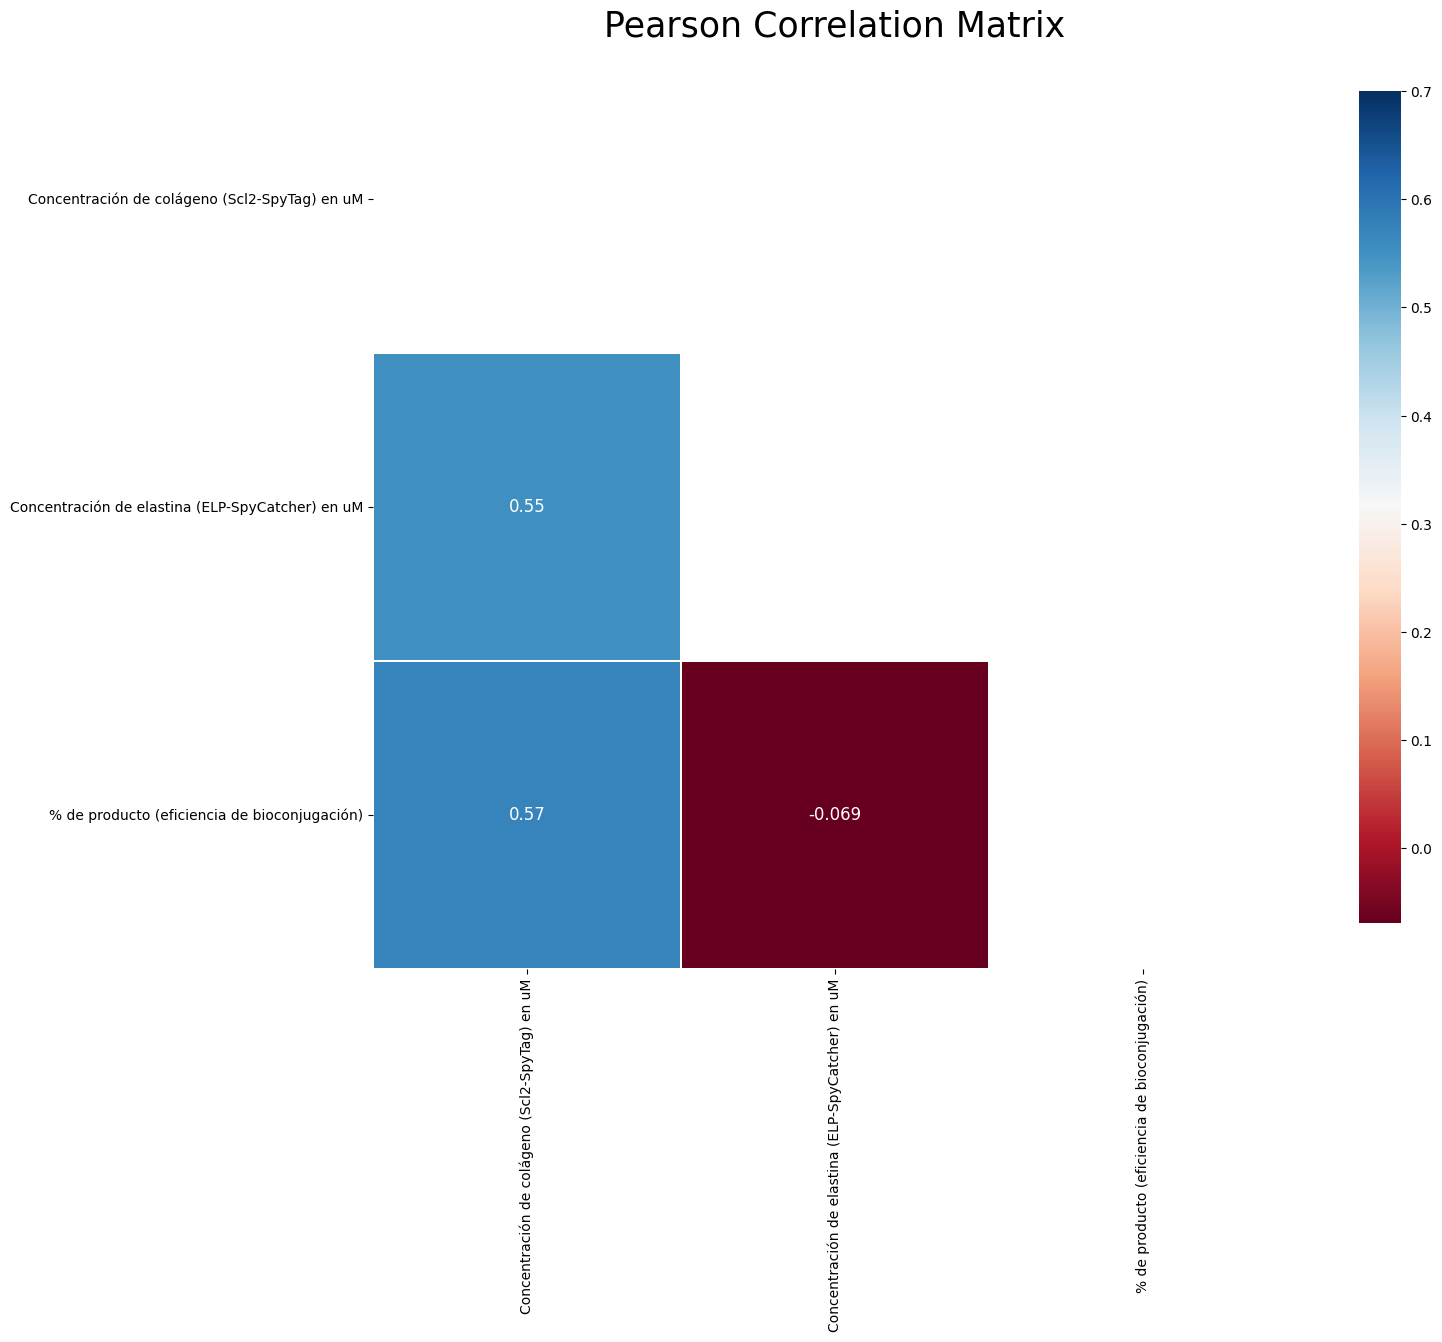

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
data_peru = pd.read_csv('peru.csv')

for col in data.columns:
     data_peru[col] = pd.to_numeric(data_peru[col], errors='coerce')
numerical_data = data_peru.select_dtypes(include=[np.number])


mask = np.zeros_like(numerical_data.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(numerical_data.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="RdBu",
            linecolor='w',annot=True,annot_kws={"size":12},mask=mask,cbar_kws={"shrink": .9});

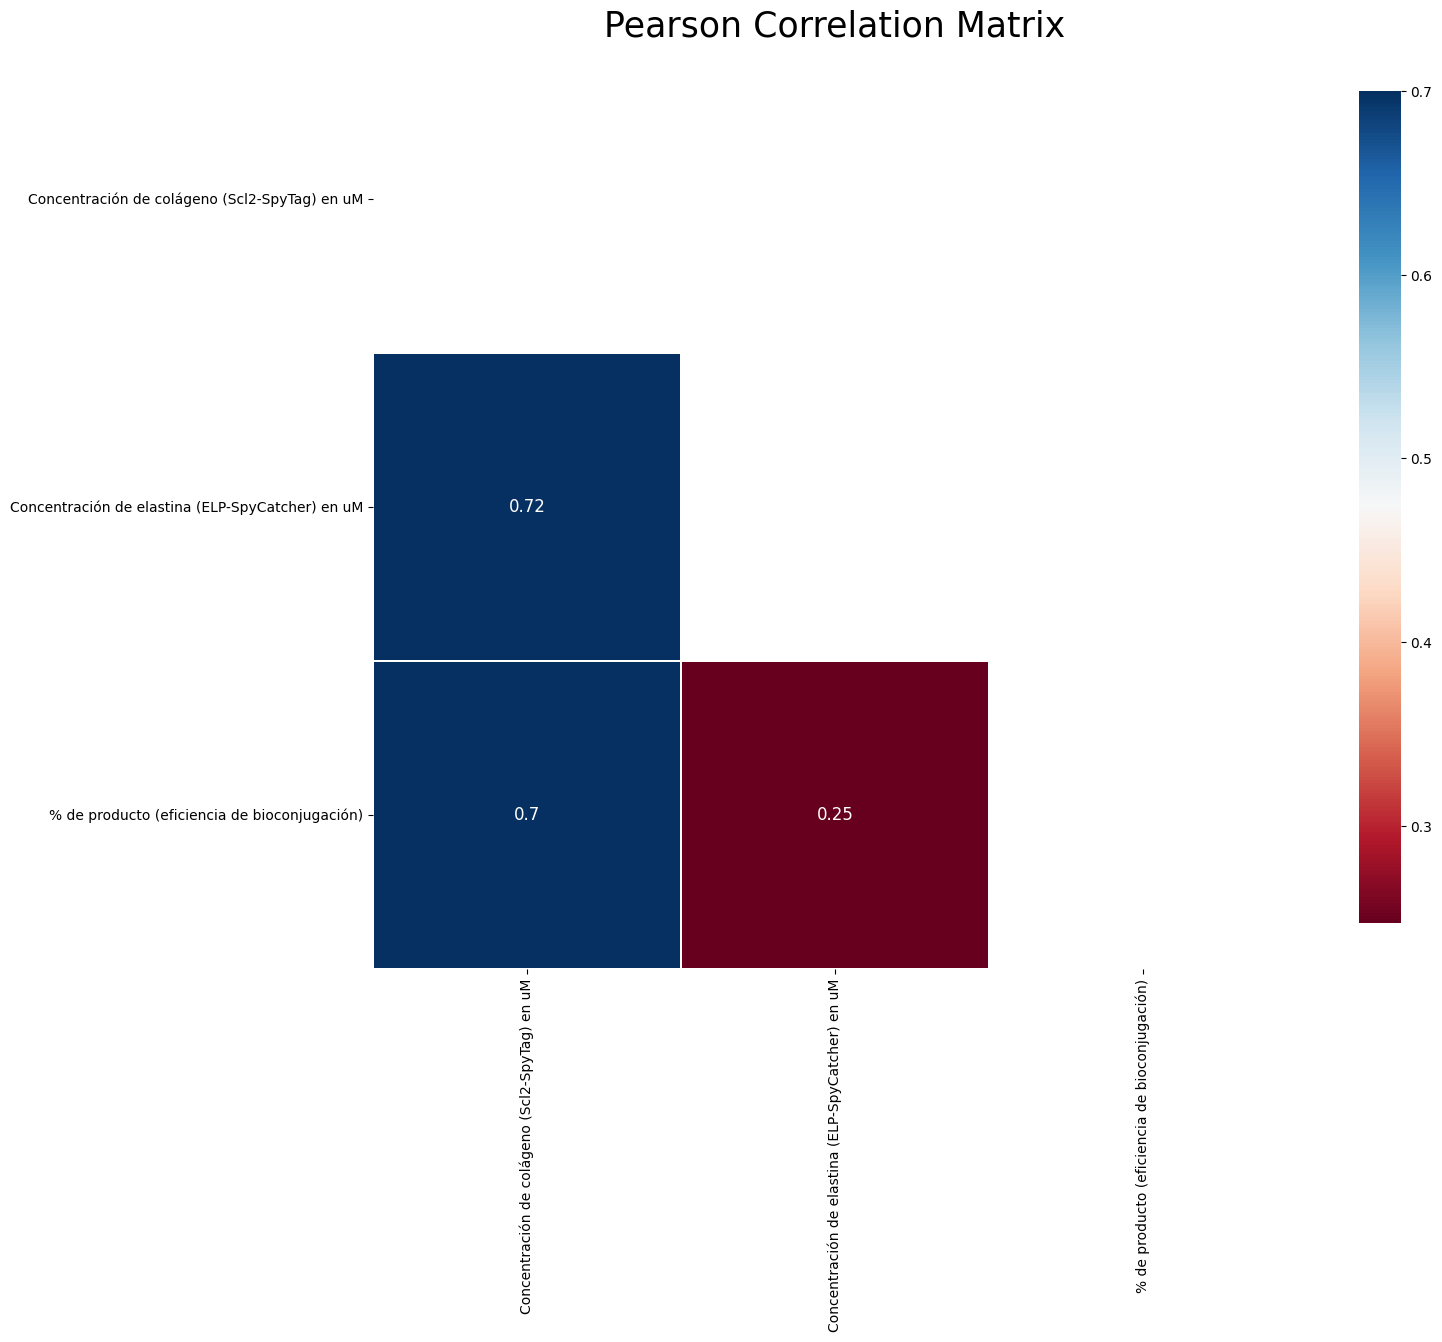

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('data_final.csv')


for col in data.columns:
     data[col] = pd.to_numeric(data[col], errors='coerce')
numerical_data = data.select_dtypes(include=[np.number])


mask = np.zeros_like(numerical_data.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(numerical_data.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="RdBu",
            linecolor='w',annot=True,annot_kws={"size":12},mask=mask,cbar_kws={"shrink": .9});

In [16]:
data = pd.read_csv('data_final.csv')
colum = ['Material']

encoder = OneHotEncoder(sparse=False, drop='first')

preprocessor = ColumnTransformer(
    transformers=[('cat', encoder, colum)],
    remainder='passthrough'
)

encoded = preprocessor.fit_transform(data)
encoded_df = pd.DataFrame(encoded, columns=preprocessor.get_feature_names_out())

# Concatena el dataframe original con el datframe de columnas codificadas
data_encoded = pd.concat([data, encoded_df], axis=1)
print(len(data_encoded))

ValueError: A given column is not a column of the dataframe

In [12]:
data = pd.read_csv('data_final.csv')
target_columns = ['Concentración de colágeno (Scl2-SpyTag) en uM', 'Concentración de elastina (ELP-SpyCatcher) en uM']
X = data.drop(columns=target_columns).values
y = data[target_columns].values #variables objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.isnan(y_test).sum())

0


In [13]:
X_train_numeric = np.where(X_train == '-', np.nan, X_train)
X_train_numeric = X_train_numeric.astype(np.float64)
mask = ~np.isnan(X_train_numeric).any(axis=1)
X_train_numeric = X_train_numeric[mask]
y_train = y_train[mask]
print(np.isnan(X_train_numeric).sum())

0


In [14]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean') #rellenar valores faltantes en caso de existir con el promedio
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [15]:
model = MLPRegressor(hidden_layer_sizes=(350,100), activation='relu', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(350, 100), max_iter=1000, random_state=42)

In [16]:
y_pred = model.predict(X_test_scaled)

In [17]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.2f}')
print(f'R2: {r2:.2f}')

MSE: 0.23
R2: -0.06


In [ ]:
print(y_pred)
column_names = ['mod_elasticidad_aproximado_Mpsi','Res_max_tension_Mpa']
y_pred_df = pd.DataFrame(data=y_pred, columns=column_names)

# Guardar el dataframe en un archivo CSV
y_pred_df.to_csv('resultados_prediccion.csv', index=False)

[[2.33141371 2.74007819]
 [2.55573449 2.99697188]
 [2.35860985 2.77374293]
 [2.61608753 3.04286897]
 [2.60351511 3.03973459]
 [2.47753314 2.93876444]
 [2.32179015 2.72706598]
 [2.4633868  2.91523713]
 [2.36873435 2.78840189]
 [2.42327379 2.84906824]
 [2.66928709 3.06919299]
 [2.32530733 2.73186862]
 [2.35242101 2.76579007]
 [2.34840493 2.7608746 ]
 [2.62322313 3.04588914]
 [2.64179068 3.05483345]
 [2.61624562 3.04293588]
 [2.33999836 2.75058537]
 [2.32223866 2.72767841]
 [2.39859362 2.82438929]
 [2.32301111 2.72873317]
 [2.35609065 2.77028152]
 [2.40779213 2.83303404]
 [2.32364109 2.7295934 ]
 [2.63668587 3.05158819]
 [2.60242335 3.03917646]
 [2.39446245 2.82050683]
 [2.32845295 2.73616392]
 [2.57220026 3.01450891]
 [2.60549439 3.0402228 ]
 [2.38634418 2.8128773 ]
 [2.3288109  2.73665269]
 [2.51586192 2.96758309]
 [2.32320762 2.7290015 ]
 [2.55728147 2.99860323]
 [2.33010988 2.73842643]
 [2.53750408 2.97929823]
 [2.32319616 2.72898586]
 [2.45883218 2.90515743]
 [2.62337968 3.0459554 ]


In [ ]:
hidden_layer_configurations = [
    (10),(10,10),(20),(30),(40), (50), (60), (64,32) , (100,), (200,), (300,),
    (100, 50), (200, 100), (300, 150),
    (100, 50, 25), (200, 100, 50), (300, 150, 75), (350,100), (400,100),(500,100),(1000),(1500),(2000), (3000)
]


results = []

for config in hidden_layer_configurations:

    model = MLPRegressor(hidden_layer_sizes=config, activation='relu', max_iter=2000, random_state=42)


    model.fit(X_train_scaled, y_train)


    y_pred = model.predict(X_test_scaled)


    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    results.append({
        'hidden_layers': config,
        'MSE': mse,
        'R2': r2
    })

results_df = pd.DataFrame(results)

results_df.to_csv('results_vae.csv', sep=',', index=False)



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce